In [24]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import scale

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

from xgboost.sklearn import XGBRegressor
import xgboost as xgb

import math

In [25]:
ind_merged_dataset = pd.read_csv("Industrial_regr.csv")

In [26]:
ind_merged_dataset.columns

Index(['Year', 'Month', 'Cents/kWh', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area',
       'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
       'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'WV', 'WY', 'industrial_usage', 'Total', 'Population',
       'solar-generation', 'Season_Fall', 'Season_Spring', 'Season_Summer',
       'Season_Winter'],
      dtype='object')

In [27]:
nc_ind_data = ind_merged_dataset.loc[ind_merged_dataset['NC'] == 1]


In [28]:
nc_ind_data = nc_ind_data.drop(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL',
       'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV', 'WY'], axis=1)
nc_ind_data

,Year,Month,Cents/kWh,CLDD,TAVG,AWND,HTDD,area,NC,industrial_usage,Total,Population,solar-generation,Season_Fall,Season_Spring,Season_Summer,Season_Winter
26,2014,1,6.41,0.036842,34.824737,6.545833,923.084211,53819,1,2011,13238511.41,9932887,0,0,0,0,1
76,2014,2,6.61,0.282609,42.568108,6.730435,623.440217,53819,1,1939,10405166.73,9941117,0,0,0,0,1
126,2014,3,6.51,0.213542,45.542708,7.891304,597.515625,53819,1,2263,10744913.74,9949347,0,0,1,0,0
176,2014,4,6.22,26.452632,58.850000,7.800000,209.405263,53819,1,2134,8245466.38,9957577,0,0,1,0,0
226,2014,5,6.33,153.282486,68.235196,5.977273,55.604520,53819,1,2479,10559710.52,9965807,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3376,2019,8,6.56,357.320442,76.500000,5.713043,3.685083,53819,1,2339,13568356.00,10550191,1,0,0,1,0
3426,2019,9,6.61,296.648352,74.737912,5.863636,5.615385,53819,1,2283,12139346.00,10559063,1,1,0,0,0
3476,2019,10,6.39,91.925926,64.167895,6.526087,118.597884,53819,1,2230,9982424.00,10567936,1,1,0,0,0
3526,2019,11,5.86,0.443243,47.063784,7.119048,533.767568,53819,1,2017,10506306.00,10576808,0,1,0,0,0


In [29]:
numeric_feature_name = ['Cents/kWh','CLDD', 'AWND', 'HTDD', 'TAVG', 'area',
                        'Population', 'solar-generation']

categorical_feature_name = ['Year', 'Month', 'Season_Spring', 'Season_Summer', 'Season_Fall', 'Season_Winter']

# fetch the respective numeric, categorical and output values
ind_numeric_features = pd.DataFrame(nc_ind_data[numeric_feature_name])
ind_categorical_features = pd.DataFrame(nc_ind_data[categorical_feature_name])
ind_y_val = pd.DataFrame(nc_ind_data['industrial_usage'])

# reindex the unscaled dataframes to simplify the concatenation
ind_categorical_features = ind_categorical_features.reset_index(drop=True)
ind_y_val = ind_y_val.reset_index(drop=True)

In [30]:
# use min_max scaler to scale data
# max_abs_scaler = preprocessing.MaxAbsScaler()
max_abs_scaler = preprocessing.MaxAbsScaler()
ind_numeric_minmax = max_abs_scaler.fit_transform(ind_numeric_features)

In [31]:
df_ind_numeric = pd.DataFrame(ind_numeric_minmax, columns=numeric_feature_name)


In [32]:
# concatenate the new numeric value and the categorical value
df_ind_train = pd.concat([ind_categorical_features, df_ind_numeric, ind_y_val], axis=1)



In [10]:
# the input into the regression function
regr_ind = df_ind_train.drop(['Year', 'Month', 'Season_Spring'],axis = 1)


In [11]:
#Train-Test Split
train, test = train_test_split(regr_ind, test_size=0.2)

X_train = train.drop(['industrial_usage'],axis = 1)
y_train = train['industrial_usage']
X_test = test.drop(['industrial_usage'],axis = 1)
y_test = test['industrial_usage']

In [12]:
def evaluate_performances(y_test, y_pred):
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred)))

In [13]:
#Visualize the output

def visualize_graph(df_pred):
    fig, axes = plt.subplots(3,1, figsize=(7,15))
    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[0])
    #Plot the scatter plot 
    df_pred.plot.scatter(title="Actual vs. Predict result scatter plot",  x='Actual',y='Predicted', c='DarkBlue',ax=axes[1])
    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[2])

In [14]:
K = 5
model = XGBRegressor(objective ='reg:squarederror')
scores = cross_val_score(model, X_train, y_train, cv=K, scoring='neg_mean_squared_error', verbose=False)
avg_rmse = math.sqrt(abs(np.mean(scores)))

print('Average RMSE with {}-fold Cross Validation: {:.3f}'.format(K, avg_rmse))

Average RMSE with 5-fold Cross Validation: 143.387


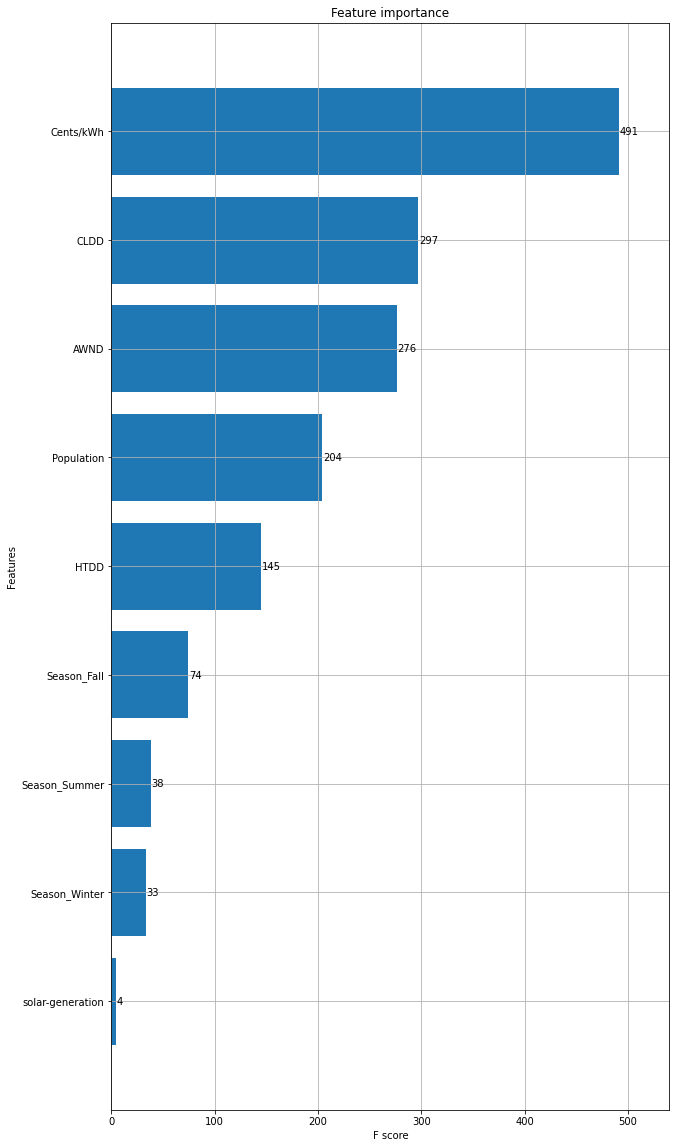

In [15]:
model = XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10,20))
xgb.plot_importance(model, height=0.8, ax=ax)

In [16]:
def sm_regression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train)
    results = model.fit()
    results.params
    print(results.summary())
    predictions = results.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
    
    return df_pred

In [17]:
sm_regression(X_train, y_train, X_test, y_test)

                            OLS Regression Results                            
Dep. Variable:       industrial_usage   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     9.066
Date:                Sun, 19 Jul 2020   Prob (F-statistic):           8.77e-08
Time:                        17:16:08   Log-Likelihood:                -343.61
No. Observations:                  57   AIC:                             707.2
Df Residuals:                      47   BIC:                             727.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4900.7665   1497.146  

,Actual,Predicted
61,1918,2034.512923
71,2206,1993.115829
29,2362,2374.780743
25,2162,1977.183844
5,2380,2428.025470
14,1949,2292.595671
16,2536,2404.287641
30,2526,2465.121711
0,2011,2136.025753
42,2379,2467.368122


Mean Absolute Error: 128.04039434670065
Mean Squared Error: 24134.39316155226
Root Mean Squared Error: 155.3524803842934


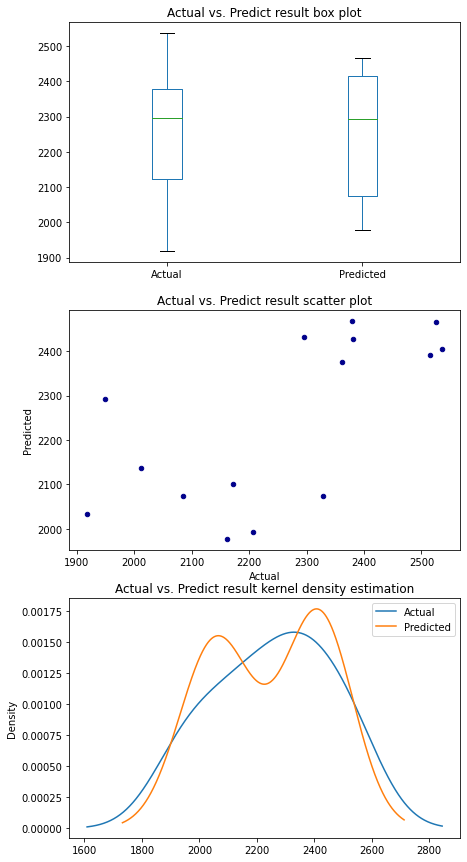

In [18]:
ind_lr = LinearRegression()
ind_lr.fit(X_train, y_train)
ind_predictions = ind_lr.predict(X_test)
evaluate_performances(y_test, ind_predictions)
ind_df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': ind_predictions})
visualize_graph(ind_df_pred)

In [19]:
a  = ind_lr.intercept_#截距
b = ind_lr.coef_#回归系数
print("最佳拟合线:截距",a,",回归系数：",b)

最佳拟合线:截距 4900.766539165374 ,回归系数： [  -64.67374896  -112.96445017  -244.65164902  -392.4866874
   236.11242627  -660.98079615   106.63148924 -1887.71536199
    87.40613739]


In [33]:
def cal_vif(df):
    features= df[['Cents/kWh', 'CLDD', 'AWND', 'HTDD', 'Population', 'TAVG', 'area']]
    X = add_constant(features)
    vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    
    return vif

In [34]:
cal_vif(df_ind_train)

Cents/kWh         2.583849
CLDD            105.036736
AWND              1.601164
HTDD            370.549805
Population        1.438008
TAVG            777.178386
area          21558.240577
dtype: float64

In [22]:
# Visualization
def visualization(y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,20))
    fig.suptitle('Predicted and Actual plot')
    ax1.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax1.legend(loc="upper right")
    ax2.plot(range(len(y_pred)),y_pred,'r',label="actual")
    ax2.legend(loc="upper right")
    ax3.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax3.plot(range(len(y_pred)),y_test,'r',label="test")
    ax3.legend(loc="upper right")
    plt.show()

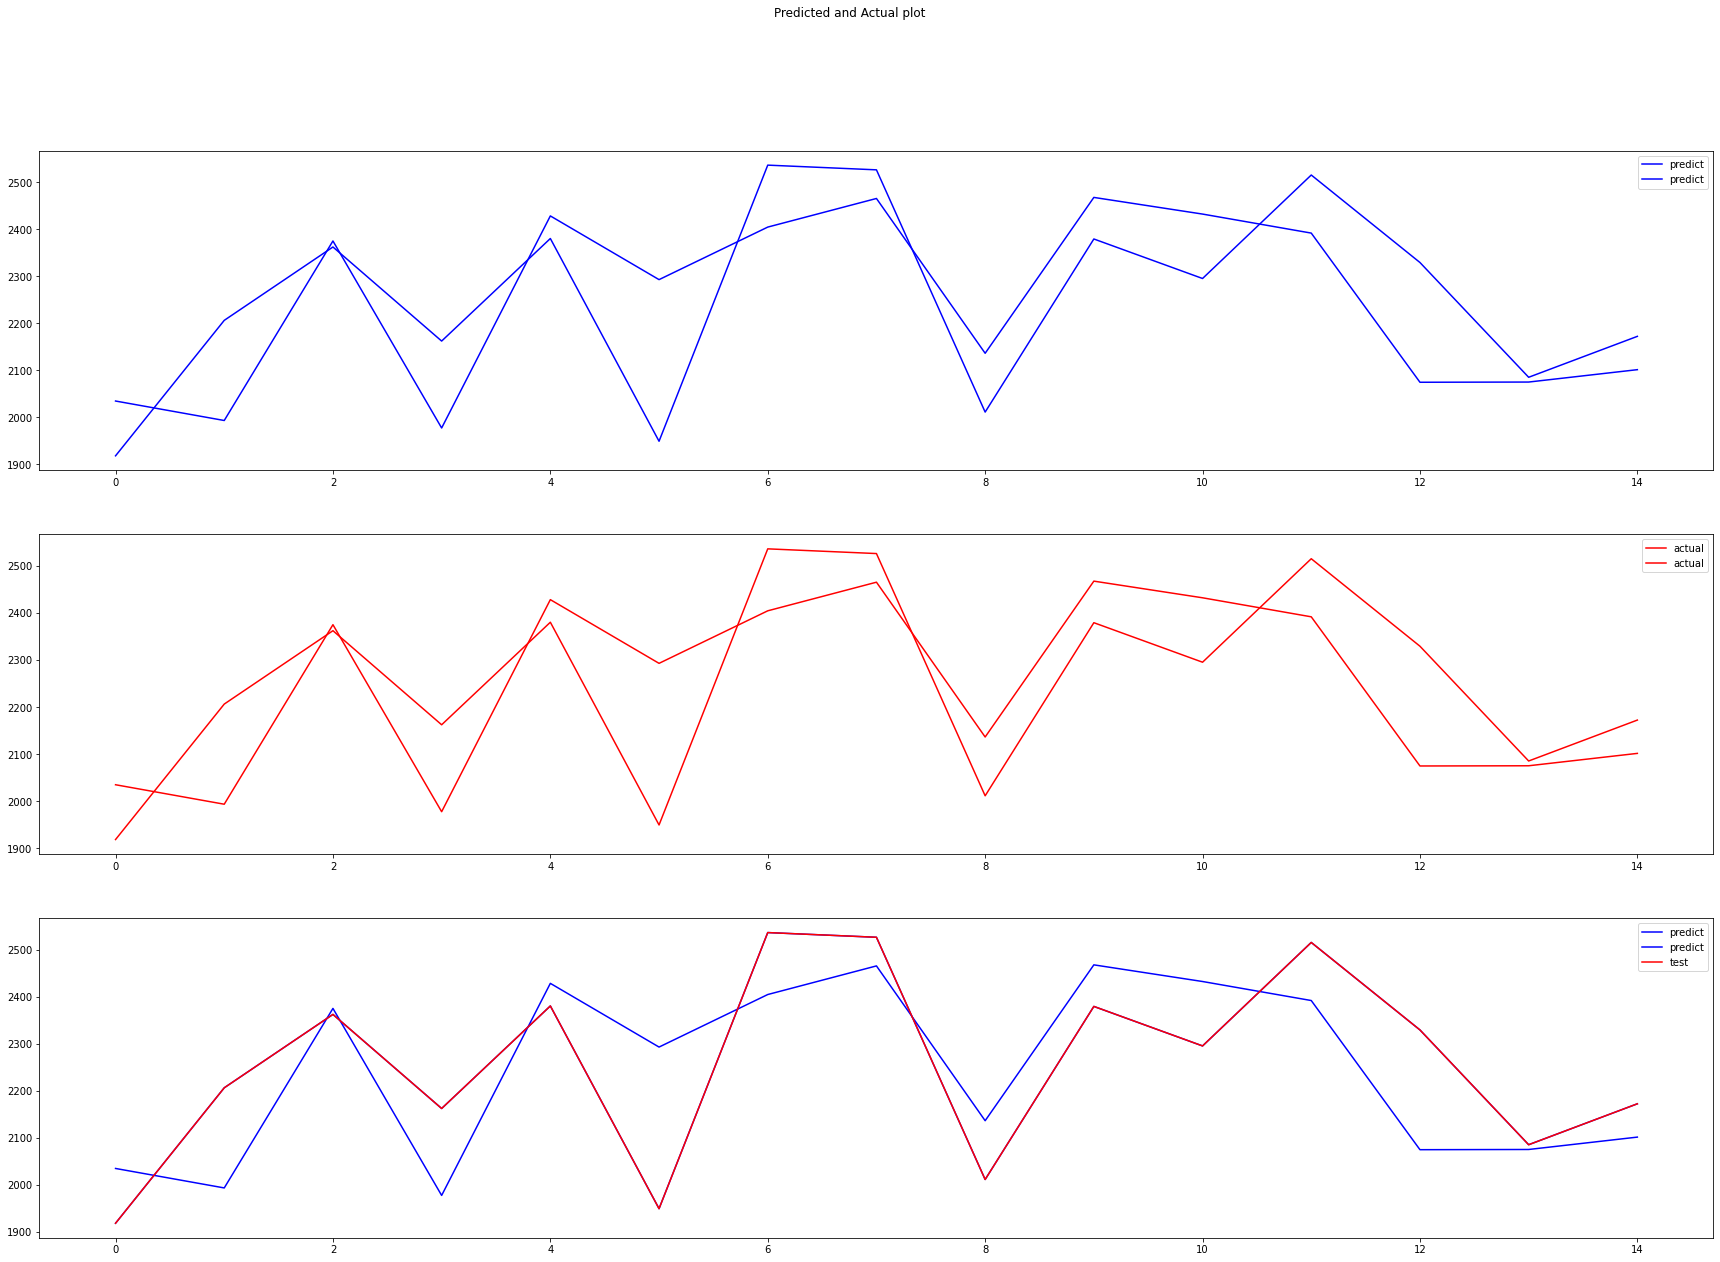

In [23]:
visualization(ind_df_pred)